<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/09_skimlit_nlp_milestone_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2 SkimLit

The purpose of this model is to build an NLP to make reading medical abstracts easier.
Ref the original paper: https://arxiv.org/pdf/1710.06071.pdf

The model architecture is described here: https://arxiv.org/pdf/1612.05251.pdf


In [1]:
!nvidia-smi

Mon Mar 13 14:49:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# get helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results


--2023-03-13 14:49:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-13 14:49:34 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get data
Since we'll be replicating the paper above, let's download the dataset theyused. We can do so from the author's github
https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.06 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# check what files we're doing in the pubmed-20K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


* note that dev is another name for validation_set
* we need a preprocessing function to read the text files and turn them into data and labels

In [5]:
# start our experiments using the 20K datasetwith numbers replaced by @ sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## preprocess data

one of the best ways to become one with the data is to VISUALIZE VISUALIZE VISUALZE

* create a function to read in all the lines to a target text file

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  reads filename (a text filename) and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath
  Returns: 
  a list of strings with noe string per line  from the target filename
  """

  with open (filename, "r") as f:
    return f.readlines()

In [7]:
# let's test this out

train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

* let's think about how we want our data to look...
* how I think our data would be best represented...

```
[{'line_number': 0,
'target': 'BACKGROUND',
'text': "Emotional eating is associated with overeating and the development of obesity .\n"
'total_lines': 11},
...
]
```


* Let's write a function that changes text to line numbers

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  returns a list of dictionaries of abstract line data.
  takes in filenames, reads its contents and sorts through each line
  extracting things like target label, the text of the sentence, 
  how many sentences are in the current abstract
  and waht sentence number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts, we're returning a list of dictionaries, remember?
  
  # loop through each line in the target file
  for line in input_lines:
    if  line.startswith("###"): # check to see if this is an id line. this tells us that a new abstract is starting
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): #checking to see if this is a newline character
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # iterate through each line in a single abstract and acoun tthem at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # splits target label from text
        # 'BACKGROUND\tEmotional eating is associated with overeating and the development of obesity .\n' -> split at /t
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number does this line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # so that this starts from zero
        abstract_samples.append(line_data) # add line data dictionary to the abstract samples list
      
    else: # if the above conditions are not fulfilled, the line contains a labelled sentence...
        abstract_lines +=line
  return abstract_samples
 

In [10]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")


CPU times: user 341 ms, sys: 77 ms, total: 418 ms
Wall time: 419 ms


In [11]:
len(test_samples), len(train_samples), len(val_samples)

(30135, 180040, 30212)

In [12]:
val_samples[32]

{'target': 'BACKGROUND',
 'text': 'patient adherence to appointments is key to improving outcomes in health care .',
 'line_number': 0,
 'total_lines': 9}

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it...

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(25)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

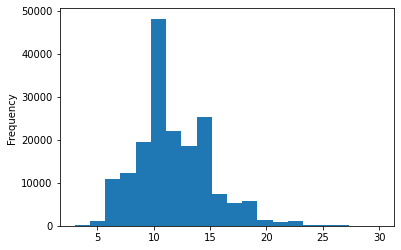

In [15]:
# let's check the length of different lines
train_df.total_lines.plot.hist(bins=20)

### get lists of sentences

In [16]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# view the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [18]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## making numeric labels (ML models require numeric labels)

In [19]:
# we're going to both label and one-hot encode the labels (target)
train_df["target"]

0           OBJECTIVE
1             METHODS
2             METHODS
3             METHODS
4             METHODS
             ...     
180035        RESULTS
180036        RESULTS
180037        RESULTS
180038    CONCLUSIONS
180039    CONCLUSIONS
Name: target, Length: 180040, dtype: object

In [20]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [22]:
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

## label encode labels


In [23]:
# extract lanbels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [24]:
len(train_labels_encoded)

180040

In [25]:
# get class names for the labels i.e. map the numeric versions of the labels into text

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments
As usual, we're going to try out a bunch of different models and see which one works best.
As usual, we'll start with a baseline TFIDF multimonial Naive Bayes classifier.

# Model 0: Baseline model

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [27]:
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

# fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# evaluate baseline model on validation dataset
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [29]:
# make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [30]:
baseline_results = calculate_results(y_true = val_labels_encoded, y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Preparing our data (the text) for deep sequence models

before we start building deeper models, we've got to create vectorization and embedding layers

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [32]:
# how long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

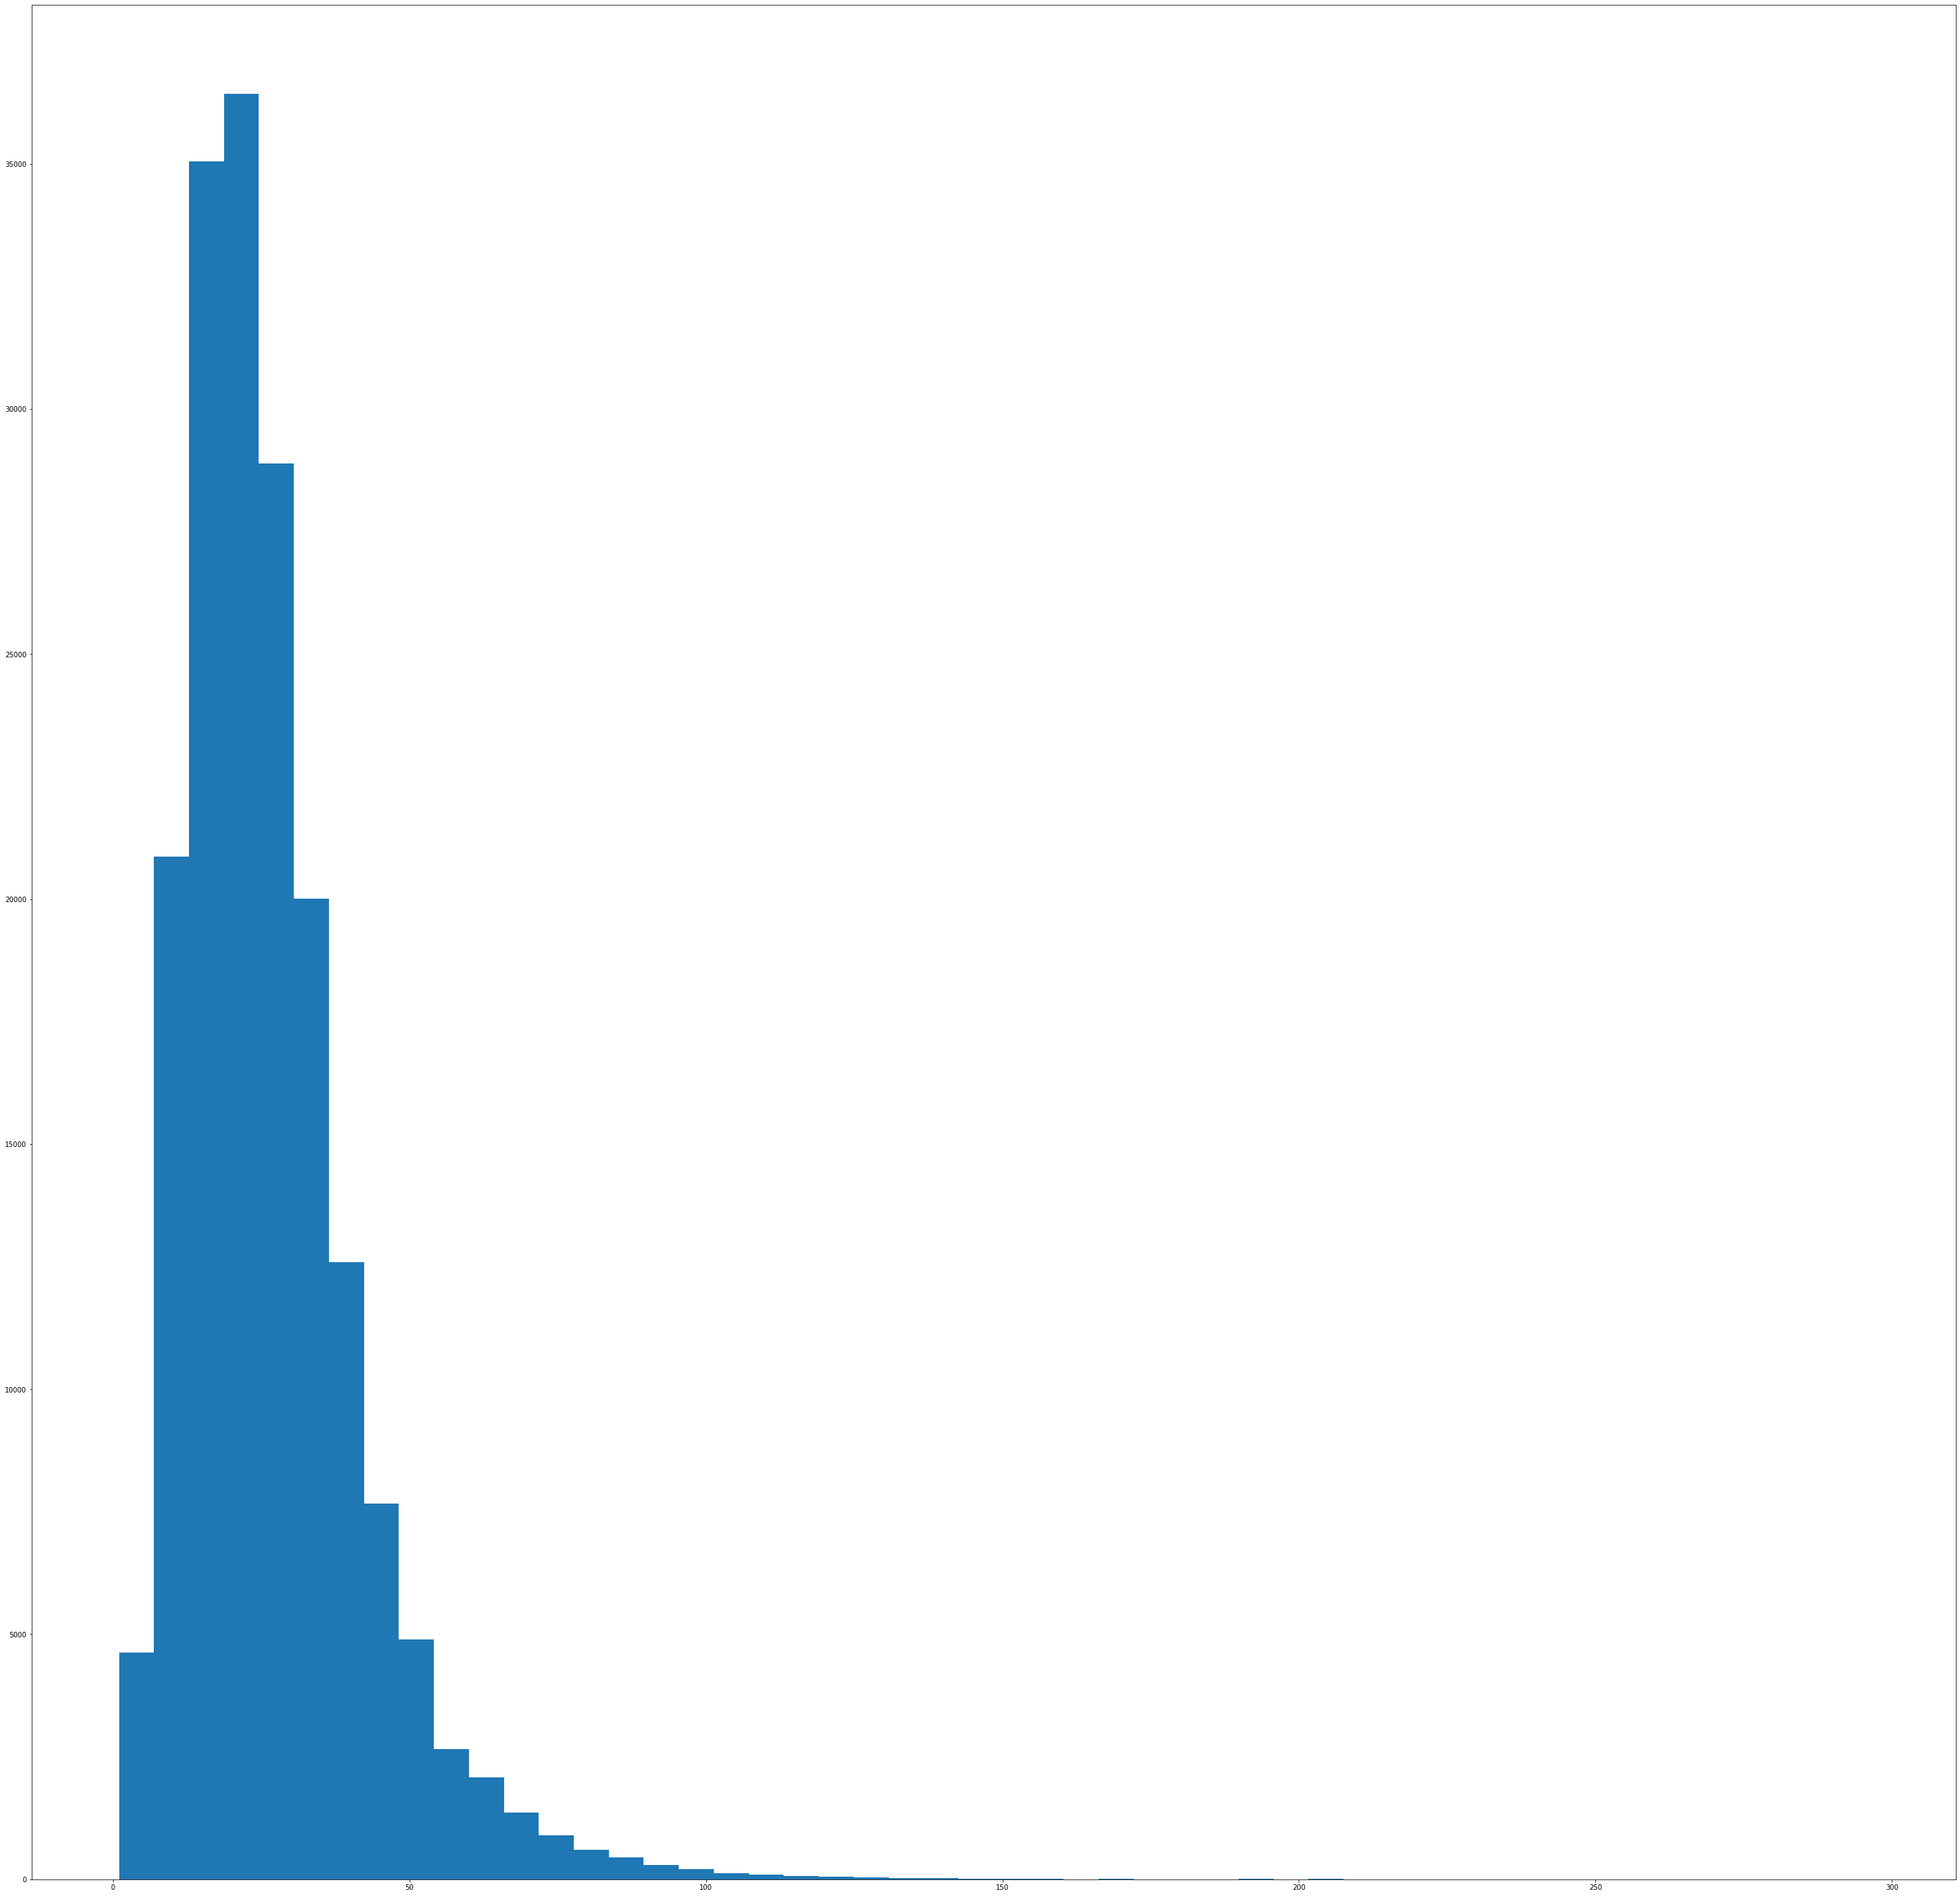

In [33]:
# what's the distribution look like?
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
plt.hist(sent_lens, bins=50);

In [34]:
# how long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
max(sent_lens)

296

### create text vectorizer layer

we want to make a layer w hich maps our text from words into numbers

* the number of word sin our vocab is taken from table 2 in the papaer


In [36]:
max_tokens = 68000 # taken from the paper

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [37]:
# add text vectorizer to training sentences...
text_vectorizer.adapt(train_sentences)

In [38]:
# how many words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

* technically we can build a model from this... but creating an embedding layer is better

In [40]:
from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                        output_dim=128,
                        mask_zero=True, # helps tensorflow do more efficient computing where there are a lot of zeros
                        name = "token_embedding")

In [41]:
# test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 pf-@ at @ mg/d was associated with increased adverse events and cognitive decline .

Length of text: 83

Vectorized text: [[3847   15 1306   10   81    7   96  118  124    3  301 1078    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [42]:
# test with embedding example...
print(f"setnence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])

print(f"sentence after vectorization:\n {vectorized_sentence}")
print(vectorized_sentence.shape)
embedded_sentence = token_embed(vectorized_sentence)
print(f"sentence after embedding:\n {embedded_sentence}")
print(f"Embedded shape: {embedded_sentence.shape}")

setnence before vectorization:
 pf-@ at @ mg/d was associated with increased adverse events and cognitive decline .
sentence after vectorization:
 [[3847   15 1306   10   81    7   96  118  124    3  301 1078    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
(1, 55)
sentence after embedding:
 [[[ 0.03437339 -0.02889364 -0.03059349 ... -0.00962052  0.01171094
    0.02573742]
  [ 0.03528604 -0.0147788  -0.03038001 ... -0.01099594  0.0038252
   -0.03824524]
  [ 0.00736398 -0.02947575 -0.04480016 ...  0.0098368  -0.04586474
   -0.04249748]
  ...
  [ 0.01051299 -0.0191088  -0.01434243 ...  0.02648645 -0.0147639
   -0.04484877]
  [ 0.01051299 -0.0191088  -0.01434243 ...  0.02648645 -0.0147639
   -0.04484877]
  [ 0.01051299 -0.0191088  -0.01434243 ...  0.02648645 -0.0147639
   -0.04484877]]]
Embedded shape: (1, 55, 128)


## Creating datasets
https://www.tensorflow.org/guide/data_performance

https://www.tensorflow.org/guide/data

* we're going to set up our data to run as fast as possible with the TensorFlow tf.data API. 

In [43]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [44]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [45]:
# take the TensorSliceDataset and turn them into PreFetch and Batch dataset - to make datasets more efficient to load into models
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [47]:
# create 1D conv model to preocess sequencess
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(84, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics="accuracy")

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 84)            53844     
                                                                 
 global_average_pooling1d (G  (None, 84)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 425   

In [48]:
# fit the model
history_model_1 = model_1.fit(train_dataset, 
                              steps_per_epoch = int(0.1* len(train_dataset)),
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 47ms/step - loss: 0.9143 - accuracy: 0.6331 - val_loss: 0.6959 - val_accuracy: 0.7324
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6642 - accuracy: 0.7515 - val_loss: 0.6369 - val_accuracy: 0.7663
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6207 - accuracy: 0.7715 - val_loss: 0.5973 - val_accuracy: 0.7829


In [49]:
# evaluate on whole dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.5998 - accuracy: 0.7854


[0.5998152494430542, 0.7854495048522949]

In [50]:
# make predictions with our models
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(30212, 5)

In [51]:
model_1_pred_probs[:5]

array([[4.4778925e-01, 1.7319651e-01, 8.7323263e-02, 2.5990522e-01,
        3.1785764e-02],
       [4.3531477e-01, 2.9788098e-01, 1.1287633e-02, 2.4875835e-01,
        6.7581940e-03],
       [1.5115984e-01, 9.2383996e-03, 1.8740919e-03, 8.3768594e-01,
        4.1775926e-05],
       [1.6667826e-05, 2.0228139e-04, 9.8365271e-01, 2.0682761e-05,
        1.6107773e-02],
       [1.6100670e-03, 4.0199902e-02, 3.8013300e-01, 1.5138413e-03,
        5.7654321e-01]], dtype=float32)

In [52]:
# convert prediction probabilities to classses
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 4])>

In [53]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [54]:
model_1_predictions = class_names[model_1_preds]
len(model_1_predictions)
model_1_predictions[:10]

array(['BACKGROUND', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS',
       'METHODS', 'RESULTS', 'METHODS', 'RESULTS', 'CONCLUSIONS'],
      dtype=object)

In [55]:
model_1_results = calculate_results(y_true = val_labels_encoded, y_pred = model_1_preds)
model_1_results

{'accuracy': 78.54494902687674,
 'precision': 0.7828652162564669,
 'recall': 0.7854494902687674,
 'f1': 0.7831991880305034}

In [56]:
tf

<module 'tensorflow' from '/usr/local/lib/python3.9/dist-packages/tensorflow/__init__.py'>

In [57]:
import tensorflow as tf

# model 2: feature extraction with pretrained token embeddings

now let's use pretrained word embeddings from Tensorflow Hub, specifically the universal sentence encoder...

https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

* The input is variable length English text and the output is a 512 long vector

In [265]:
# download pretrained TensorflowHub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [266]:
# test out the pretrained embedding  on a random sentence...
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding: \n {use_embedded_sentence[0][:30]}")
print(f"lenght of the sentence embedding: \n {len(use_embedded_sentence[0])}")

Random sentence:
 this would be the first rct to answer a clinically important question which could significantly affect the operative delivery rate in australia and internationally .
Sentence after embedding: 
 [-3.55527326e-02  1.41538465e-02 -7.93769807e-02 -7.77476355e-02
 -3.45581807e-02  2.22740546e-02 -4.06131633e-02 -5.96070811e-02
  7.61499107e-02 -5.82117327e-02  5.29693402e-02 -2.69616358e-02
  3.03692333e-02 -2.09095366e-02  1.21037811e-02 -1.06021715e-02
 -1.98756736e-02  7.72405714e-02 -3.19173634e-02  3.14701349e-02
  3.65229067e-03  7.52912760e-02  4.81381714e-02  5.84919453e-02
 -6.78474244e-05  6.04968034e-02 -2.18185671e-02 -4.63996939e-02
 -2.00938024e-02  6.94396999e-03]
lenght of the sentence embedding: 
 512


In [267]:
inputs = layers.Input(shape=[], dtype = "string", name="input_layer")
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(x) # you could add more layers here if you want to
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_USE_feature_extractor")


model_2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dense_16 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [268]:
# fit model to data
history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        validation_data = valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 21ms/step - loss: 0.9124 - accuracy: 0.6503 - val_loss: 0.7972 - val_accuracy: 0.6922
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7675 - accuracy: 0.7018 - val_loss: 0.7546 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7522 - accuracy: 0.7111 - val_loss: 0.7395 - val_accuracy: 0.7124


In [269]:
# evaluate on the validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.7415 - accuracy: 0.7133


[0.7414682507514954, 0.7133258581161499]

In [270]:
# make predictions
model_2_pred_probabilities = model_2.predict(valid_dataset)
model_2_predictions = tf.argmax(model_2_pred_probabilities, axis=1)

945/945 [==============================] - 18s 18ms/step


In [271]:
model_2_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [272]:
model_2_results = calculate_results(y_true = val_labels_encoded, y_pred = model_2_predictions)
model_2_results

{'accuracy': 71.33258307957104,
 'precision': 0.7139683837319878,
 'recall': 0.7133258307957103,
 'f1': 0.7103841852173886}

In [66]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 3 Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.
Previously we've used token level embeddings but we'll need to do similar steps for characters.

In [67]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [68]:
# make function to split sentences into characters

In [69]:
def split_chars(text):
  return " ".join(list(text))

In [70]:
# text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'o v e r   h a l f   o f   t h e   c h i l d r e n   i n   e a c h   g r o u p   i m p r o v e d   t h e i r   b m i   z - s c o r e   (   a d j u s t e d   p r o p o r t i o n   d e c r e a s i n g   =   @   %   i n   c o n t r o l   v s .   @   %   i n   i n t e r v e n t i o n   ;   @   %   c i   o f   d i f f e r e n c e   =   - @   - @   )   .'

In [71]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]

val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


In [72]:
len(train_chars), len(train_sentences)

(180040, 180040)

In [73]:
# what's the average character length?
chars_len = [len(sentence) for sentence in train_sentences]
mean_chars_len = np.mean(chars_len)
mean_chars_len

149.3662574983337

(array([4.3065e+04, 8.9738e+04, 3.6231e+04, 8.4400e+03, 1.8710e+03,
        4.6700e+02, 1.3900e+02, 4.5000e+01, 2.5000e+01, 1.1000e+01,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 9.33333333e+01, 1.85666667e+02, 2.78000000e+02,
        3.70333333e+02, 4.62666667e+02, 5.55000000e+02, 6.47333333e+02,
        7.39666667e+02, 8.32000000e+02, 9.24333333e+02, 1.01666667e+03,
        1.10900000e+03, 1.20133333e+03, 1.29366667e+03, 1.38600000e+03]),
 <BarContainer object of 15 artists>)

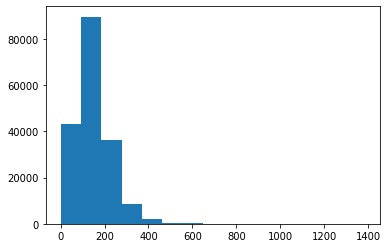

In [74]:
# check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(chars_len, bins=15)

In [75]:
# find what character lenght covers 95% of sequences
output_seq_chars_len = int(np.percentile(chars_len, 95))
output_seq_chars_len

290

In [76]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [77]:
# create char level token vectorizer instance
# NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV token

NUM_CHAR_TOKENS = 28

char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_chars_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [78]:
# adapt vectorizer to training character
char_vectorizer.adapt(train_chars)

In [79]:

# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}.")

print(f"5 most common characters: \n{char_vocab[:5]}")
print(f"5 least common characters: \n{char_vocab[-5:]}")

Number of different characters in character vocab: 28.
5 most common characters: 
['', '[UNK]', 'e', 't', 'i']
5 least common characters: 
['k', 'x', 'z', 'q', 'j']


In [80]:
# test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 e a c h   w a s   m o r e   c o m m o n   f o r   a z l i - t r e a t e d   t h a n   f o r   p l a c e b o - t r e a t e d   p a t i e n t s   ,   b u t   t h e   i n c i d e n c e s   w e r e   m o r e   b a l a n c e d   i n   a i r - b x @   .
Length of random_train_chars: 247
\Vectorized chars:
 [[ 2  5 11 13 20  5  9 15  7  8  2 11  7 15 15  7  6 17  7  8  5 25 12  4
   3  8  2  5  3  2 10  3 13  5  6 17  7  8 14 12  5 11  2 22  7  3  8  2
   5  3  2 10 14  5  3  4  2  6  3  9 22 16  3  3 13  2  4  6 11  4 10  2
   6 11  2  9 20  2  8  2 15  7  8  2 22  5 12  5  6 11  2 10  4  6  5  4
   8 22 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  

### creating the character level embedding

In [81]:
char_embed = layers.Embedding(input_dim = len(char_vocab), 
                              output_dim=25, # this is the size of the char embedding in the paper 
                              mask_zero=True,
                              name="char_embed")

In [82]:
# test our character embedding layer
print(f"Charified text: \n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text: 
e a c h   w a s   m o r e   c o m m o n   f o r   a z l i - t r e a t e d   t h a n   f o r   p l a c e b o - t r e a t e d   p a t i e n t s   ,   b u t   t h e   i n c i d e n c e s   w e r e   m o r e   b a l a n c e d   i n   a i r - b x @   .

Embedded chars (after vectorization and embedding):
 [[[-0.03611907  0.03653845 -0.0464084  ... -0.02220503 -0.04714521
   -0.00221573]
  [ 0.04033091 -0.00922778  0.02266503 ...  0.04353357  0.00498698
   -0.02953365]
  [-0.03844124 -0.03017533 -0.01182637 ... -0.00196242  0.03528323
    0.00054332]
  ...
  [-0.02757312 -0.02120078  0.0218229  ...  0.04013754  0.04167247
   -0.04875174]
  [-0.02757312 -0.02120078  0.0218229  ...  0.04013754  0.04167247
   -0.04875174]
  [-0.02757312 -0.02120078  0.0218229  ...  0.04013754  0.04167247
   -0.04875174]]]

Char embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [83]:
# Make Conv1D on chars only 
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_character_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer = "Adam",
                metrics=["accuracy"])

model_3.summary()


Model: "model_3_conv1D_character_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (No

## optimizing the dataset for character embedding

In [84]:
# create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [86]:
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1* len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1* len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2543 - accuracy: 0.4804 - val_loss: 1.0320 - val_accuracy: 0.5854
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0033 - accuracy: 0.6002 - val_loss: 0.9477 - val_accuracy: 0.6230
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9294 - accuracy: 0.6343 - val_loss: 0.8812 - val_accuracy: 0.6543


In [87]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8907 - accuracy: 0.6478


[0.8907458782196045, 0.6478220820426941]

* the evaluate result with `AveragePooling` was 0.4044

In [88]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.18706855, 0.49268723, 0.10472395, 0.15391949, 0.06160079],
       [0.28023052, 0.45518574, 0.01150254, 0.16674784, 0.08633341],
       [0.05185432, 0.19184744, 0.20739824, 0.33133578, 0.21756427],
       ...,
       [0.01686641, 0.04234302, 0.05611521, 0.02828759, 0.8563878 ],
       [0.01430657, 0.05351798, 0.40586954, 0.02272253, 0.50358343],
       [0.3648369 , 0.4794913 , 0.04736958, 0.08929162, 0.01901053]],
      dtype=float32)

In [89]:
model_3_predictions = tf.argmax(model_3_pred_probs, axis=1)
model_3_predictions[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 3, 2, 2])>

In [90]:
# Calculate the results
model_3_results = calculate_results(y_true = val_labels_encoded, y_pred = model_3_predictions)
model_3_results

{'accuracy': 64.78220574606117,
 'precision': 0.6360671467932839,
 'recall': 0.6478220574606117,
 'f1': 0.6381664434705605}

In [91]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

* This is our worst results so far.


# Model 4 - Combining a pretrained token embeddings + character embeddings (hybrid)
1. create a token-level embedding (similar to `model_1`)
2. create a character-level embedding (similar to `model_3` with a slight modification)
3. combine 1 & 2 with a concantenate (`layers.Concatenate`)
4. build a series of output layers on top of 3 similar to Fig1  and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence level probabilities as output. 

- **Drop out** means removing randomly removing some of the weights from the patterns.

In [92]:
# 1. set up the token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings) # the paper used 300
token_model = tf.keras.Model(token_inputs, token_output, name="token_model")



In [93]:
# 2. set up character level inputs/models
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
# using 24 because it's a multiple of 8, when it doubles, it's 48, although the paper is 50
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

In [94]:
# 3 concantenate token and char inputs to get hybrid embedding

token_char_concat = layers.Concatenate(name="token_char_hybrid")(
    [token_model.output, char_model.output])

In [95]:
# 4 create output layers adding in drop out, which is discussed in the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [96]:
# 5 construct model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [97]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

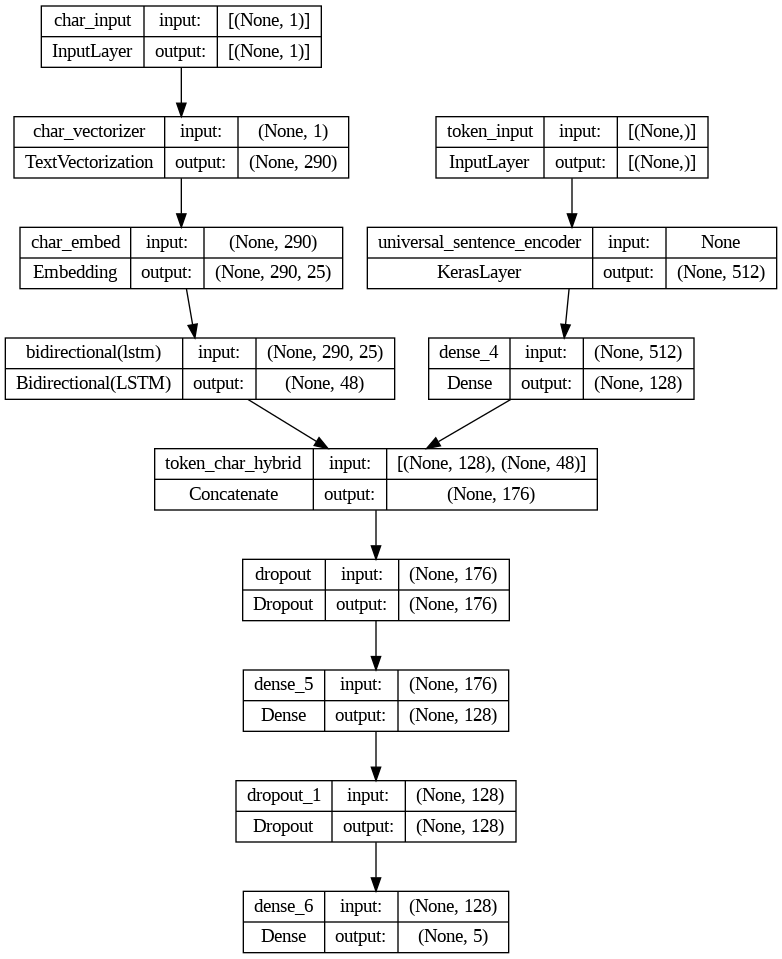

In [98]:
# plot the hybrid model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

https://medium.com/airbnb-engineering/widetext-a-multimodal-deep-learning-framework-31ce2565880c

You can combine models with different inputs - text, image, etc and concantenate all these inputs into a bigger model.


In [99]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")

### Combining token and char data into a tf.data.Dataset

In [100]:
# create the Training and Validation datasets to fit and evaluates...

train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data, train_hybrid_labels))
# prefetch and batch train data
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

                

In [101]:
# validation data and test data

val_hybrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_hybrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_hybrid_dataset = tf.data.Dataset.zip((val_hybrid_data, val_hybrid_labels))
# prefetch and batch train data
val_hybrid_dataset = val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_hybrid_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_hybrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_hybrid_dataset = tf.data.Dataset.zip((test_hybrid_data, test_hybrid_labels))
# prefetch and batch train data
test_hybrid_dataset = test_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

                

In [102]:
# check out our training char and token embedding dataset
train_hybrid_dataset, val_hybrid_dataset, test_hybrid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

* Note the order of these two

In [103]:
# fit the model
history_4 = model_4.fit(train_hybrid_dataset,
                        epochs=3,
                        steps_per_epoch = int(0.1*len(train_hybrid_dataset)),
                        validation_data = val_hybrid_dataset, 
                        validation_steps= int(0.1* len(val_hybrid_dataset)))

Epoch 1/3
562/562 [==============================] - 57s 80ms/step - loss: 0.9853 - accuracy: 0.6084 - val_loss: 0.7884 - val_accuracy: 0.6938
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8019 - accuracy: 0.6919 - val_loss: 0.7128 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 27s 47ms/step - loss: 0.7742 - accuracy: 0.7052 - val_loss: 0.6863 - val_accuracy: 0.7420


In [104]:
# Evaluate on the model's performance

In [105]:
model_4.evaluate(val_hybrid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6900 - accuracy: 0.7370


[0.690005362033844, 0.7369919419288635]

In [106]:
model_4_preds_probs = model_4.predict(val_hybrid_dataset)
model_4_predictions = tf.argmax(model_4_preds_probs, axis=1)

945/945 [==============================] - 19s 18ms/step


In [107]:
model_2_results, baseline_results

({'accuracy': 71.1008870647425,
  'precision': 0.7116904030858666,
  'recall': 0.7110088706474249,
  'f1': 0.7082095112165708},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})

In [108]:
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_predictions)


In [109]:
model_4_results

{'accuracy': 73.69919237389117,
 'precision': 0.7379795846922165,
 'recall': 0.7369919237389116,
 'f1': 0.7337047367721872}

# Model 5 with pre-trained token embedding + character embeddings + positional embedding

## Feature Engineering
(using label sequence optimizer layer)

- Taking **non-obvious** features from the data and encodding them numerically to help our model learn.

- Data augmentation is a form of feature engineering. If we know that the same image rotated, shifted, etc is still the same image, we're injecting our domain knowledge into the problem to help the model learn.

- Note that engineered features need to be available at test time.

In [110]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


* We want to find a way to encode line_number and total_lines into positional embedding

* Create a dataset for line_number/total_lines vs labels...

In [111]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


## Create a positional embedding

In [112]:
# how many line numbers are there?
train_df["line_number"].value_counts(), train_df["total_lines"].value_counts()

(0     15000
 1     15000
 2     15000
 3     15000
 4     14992
 5     14949
 6     14758
 7     14279
 8     13346
 9     11981
 10    10041
 11     7892
 12     5853
 13     4152
 14     2835
 15     1861
 16     1188
 17      751
 18      462
 19      286
 20      162
 21      101
 22       66
 23       33
 24       22
 25       14
 26        7
 27        4
 28        3
 29        1
 30        1
 Name: line_number, dtype: int64, 11    24468
 10    23639
 12    22113
 9     19400
 13    18438
 14    14610
 8     12285
 15    10768
 7      7464
 16     7429
 17     5202
 6      3353
 18     3344
 19     2480
 20     1281
 5      1146
 21      770
 22      759
 23      264
 4       215
 24      200
 25      182
 26       81
 28       58
 3        32
 30       31
 27       28
 Name: total_lines, dtype: int64)

<AxesSubplot:ylabel='Frequency'>

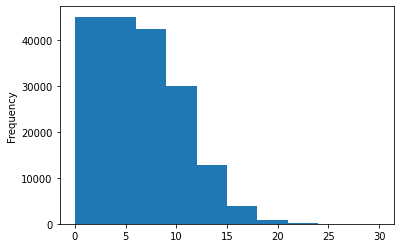

In [113]:
train_df.line_number.plot.hist()

In [114]:
# Use Tensorflow to create one-hot encoded tensors of our "line number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)

In [115]:
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

<AxesSubplot:ylabel='Frequency'>

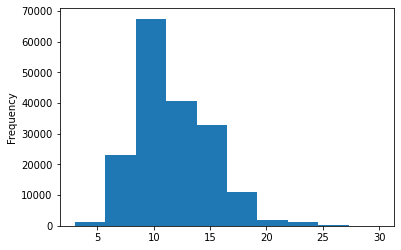

In [116]:
(train_df["total_lines"]).plot.hist()

In [117]:
# check the coverag of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [118]:
# use tensorflow to create one-hot encoded tensors of our "total_line" feature
train_total_line_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_line_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_line_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


In [119]:
train_total_line_one_hot[:2]

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

## Building a tribid embedding model

1. create a token level model
2. create a character-level model
3. create a '`line number`' model
4. create a `total_lines` feature
5. combine the outputs of 1 & 2 using `tf.keras.layers.concantenate`
6. combine the outputs of 3, 4 & 5 using `tf.keras.layers.concantenate`.
7. create an output layer to accept the tribid embedding and output label probabilities
8. combine the inputs of 1, 2, 3, 4 and output of 7 into a `tf.keras.Model`



In [120]:
# 1. token inputs
token_inputs = layers.Input(shape=[], dtype="string", name = "token_inputs")
x = tf_hub_embedding_layer(token_inputs)
x = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(token_inputs, x, name="token_model")

# 2. char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
x = char_vectorizer(char_inputs)
x = char_embed(x)
x = layers.Bidirectional(layers.LSTM(24))(x)
char_model = tf.keras.Model(char_inputs, x, name="char_model")

In [121]:
# 3. line number model
line_number_inputs = layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x, name="line_number_model")


In [122]:
# 4. total line  model
total_line_inputs = layers.Input(shape=(20,), dtype="float32", name="total_number_inputs")
y = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, y, name="line_number_model")




In [123]:
# 5. combine the outputs of 1 & 2
z = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])

# dropout 
z = layers.Dense(256, activation="relu")(z)
combined_embeddings = layers.Dropout(0.5)(z)

In [124]:
# 6. combine the outputs of 
tribid_embeddings = layers.Concatenate(name="tribid_embedding")(
    [line_number_model.output, total_line_model.output, combined_embeddings]
)

In [125]:
# 7. create output layer

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribid_embeddings)

In [126]:
# 8. create the model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input], 
                         outputs=output_layer,
                         name="model_5_tribid_embedding_model")

In [127]:
# get a summary of our model
model_5.summary()

Model: "model_5_tribid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['to

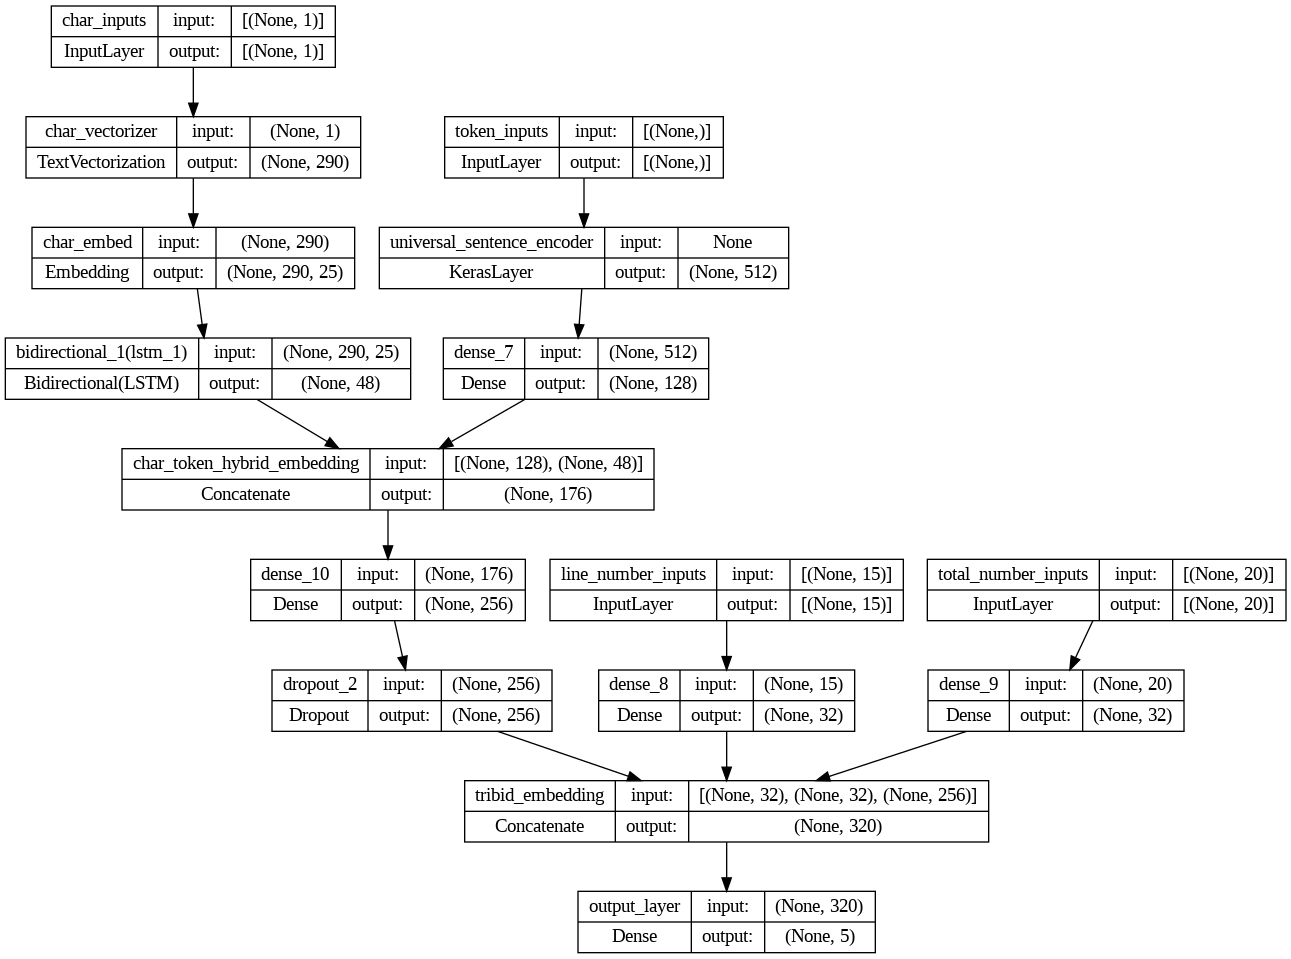

In [128]:
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [129]:
# Compile token, char and positional embedding model 
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics="accuracy")

# labels smoothening helps to prevent overfitting

### What is label smoothing?

if our nmodel gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and may not consider other classes...

Really confident -> `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does - it assigns some of the value from teh highest pred prob to the other classes, hopefully improving generalization....

Post-smoothing -> `[0.01, 0.01, 0.96, 0.01, 0.01]`

For more on label smoothing, see this blog post https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/



## Creating a dataset for model_5

In [130]:
tribid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                    train_total_line_one_hot,
                                                    train_sentences,
                                                    train_chars))
tribid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribid_dataset = tf.data.Dataset.zip((tribid_data, tribid_labels))
train_tribid_dataset = train_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [131]:
tribid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                    val_total_line_one_hot,
                                                    val_sentences,
                                                    val_chars))
tribid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribid_dataset = tf.data.Dataset.zip((tribid_data, tribid_labels))
val_tribid_dataset = val_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


tribid_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                    test_total_line_one_hot,
                                                    test_sentences,
                                                    test_chars))
tribid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribid_dataset = tf.data.Dataset.zip((tribid_data, tribid_labels))
test_tribid_dataset = test_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [132]:
train_tribid_dataset, val_tribid_dataset, test_tribid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [133]:
train_tribid_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [134]:
history_5 = model_5.fit(train_tribid_dataset,
                        epochs=3,
                        steps_per_epoch = int(0.1*len(train_tribid_dataset)),
                        validation_data = val_tribid_dataset,
                        validation_steps = int(0.05*len(val_tribid_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 53ms/step - loss: 1.0958 - accuracy: 0.7270 - val_loss: 0.9885 - val_accuracy: 0.7979
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9679 - accuracy: 0.8155 - val_loss: 0.9575 - val_accuracy: 0.8231
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9498 - accuracy: 0.8237 - val_loss: 0.9484 - val_accuracy: 0.8251


In [135]:
model_5_pred_probs = model_5.predict(val_tribid_dataset, verbose=1)

945/945 [==============================] - 23s 21ms/step


In [136]:
# Calculate results

model_5_predictions = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded, 
                                    y_pred=model_5_predictions)

# Compare model results

In [137]:
# combine model results into dictionary
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1_custom_token_embedding": model_1_results, 
                                 "model_2_pretrained_token_embedding": model_2_results,
                                 "model_3_char_embedding": model_3_results,
                                 "model_4_hybrid_char_token_embedding": model_4_results,
                                 "model_5_tribid_char_token_position_embedding": model_5_results})

all_model_results = all_model_results.transpose()

all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.785449,0.782865,0.785449,0.783199
model_2_pretrained_token_embedding,0.711009,0.711690,0.711009,0.708210
model_3_char_embedding,0.647822,0.636067,0.647822,0.638166
model_4_hybrid_char_token_embedding,0.736992,0.737980,0.736992,0.733705
model_5_tribid_char_token_position_embedding,0.833874,0.833344,0.833874,0.832488


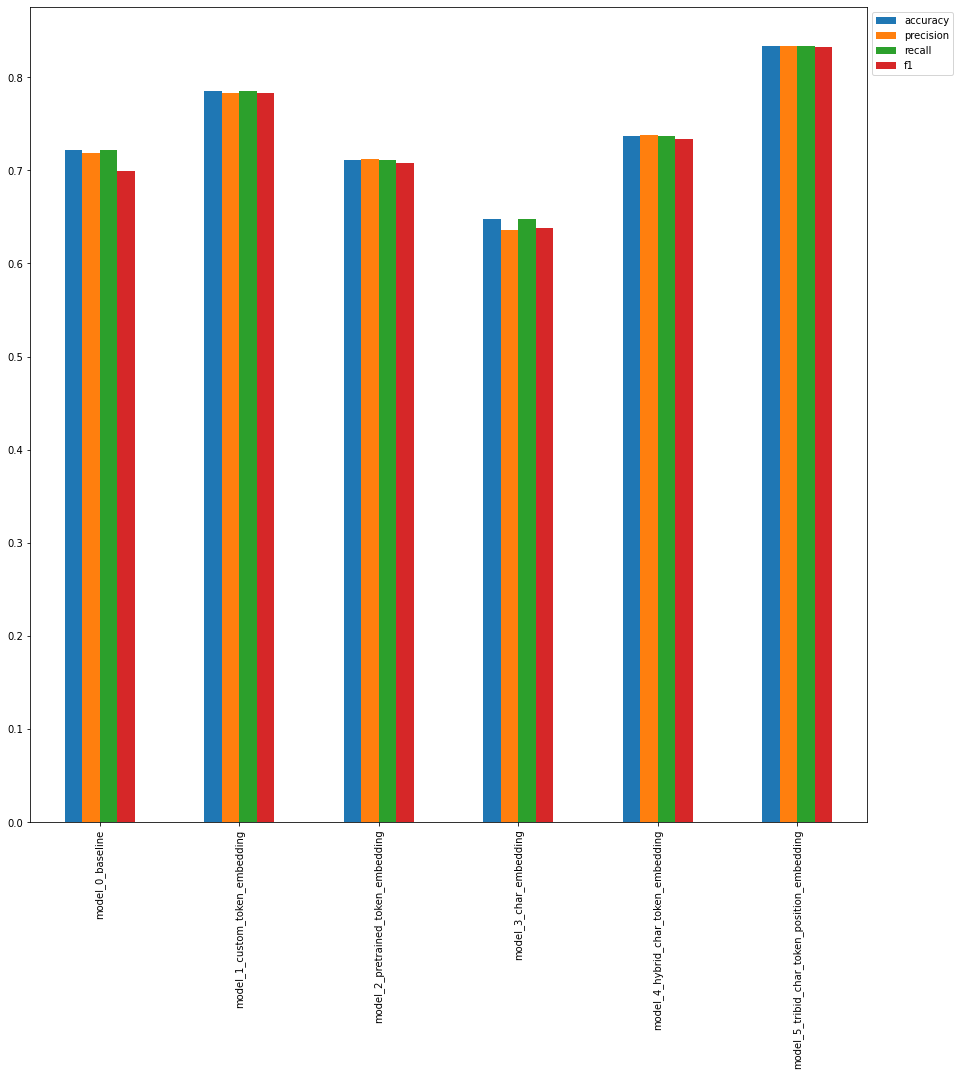

In [138]:
# Plot and compare all model results

all_model_results.plot(kind="bar", figsize=(15,15)).legend(bbox_to_anchor=(1.0,1.0));

<AxesSubplot:>

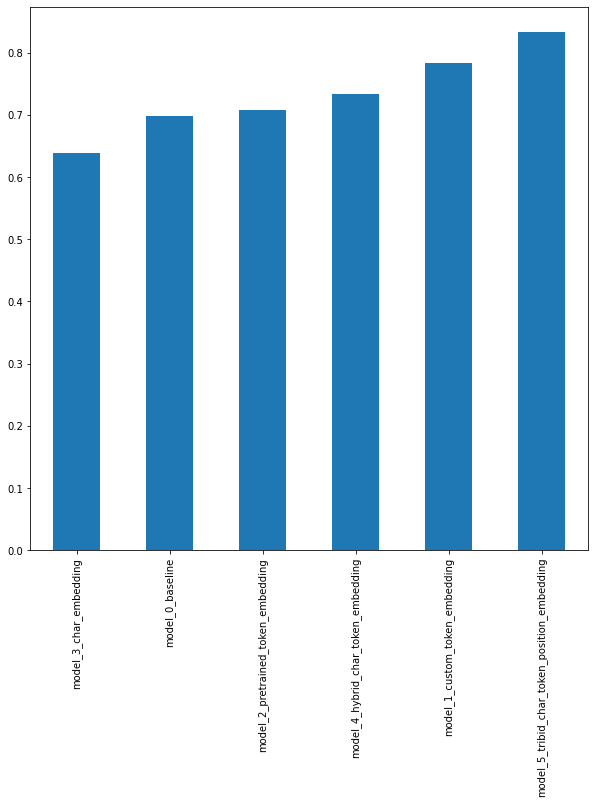

In [139]:
# sort models by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,10))

In [140]:
# Saving and loading models

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [142]:

model_5

In [143]:
model_5.save("save")

In [144]:
model_5.save("/content/drive/MyDrive/ML_Tensor/skimlit_tribid_model")

In [145]:
loaded_model = tf.keras.models.load_model("save")

In [146]:
loaded_model

In [160]:
# make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_tribid_dataset)
loaded_predictions = tf.argmax(loaded_pred_probs, axis=1)
loaded_predictions[:10], model_5_predictions[:10]

945/945 [==============================] - 23s 24ms/step


(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>)

In [148]:
# calculate results of loaded model
loaded_model_results = calculate_results (y_true=val_labels_encoded, 
                                          y_pred=loaded_predictions)
loaded_model_results, model_5_results

({'accuracy': 83.38739573679332,
  'precision': 0.8333437984209839,
  'recall': 0.8338739573679332,
  'f1': 0.8324875589353418},
 {'accuracy': 83.38739573679332,
  'precision': 0.8333437984209839,
  'recall': 0.8338739573679332,
  'f1': 0.8324875589353418})

In [149]:
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)


array([ True,  True,  True,  True])

# Challenges

1. Turn test data sample into a tf.data data, evaluate and make predict ✅
2. Find the most wrong predictions from 1
3. Make example predictions (on RCT abstracts from the wild)

Most wrong predictions would be the predictions with the highest probabilities for their results which are not true.

So y_true[sentence] != y_pred[sentence] and 
y_pred[sentence]> high

Select all the y_pred for y_true[sentence] != y_pred[sentence] 

sort in order of the value of y_pred_probs


In [190]:
# merge the dataset



Results = pd.DataFrame(zip(tf.reduce_max(loaded_pred_probs, axis=1).numpy(), loaded_predictions.numpy(), val_labels_encoded),
                             columns = ["Probabilities", "Predictions","GroundTruth"])


In [183]:
Results.head()

,Probabilities,Predictions,GroundTruth
0,0.516556,0,0
1,0.534904,0,0
2,0.384991,3,3
3,0.686411,2,2
4,0.672310,2,2


In [191]:
# sort and filter
Sorted_Results = Results[Results.Predictions != Results.GroundTruth].sort_values(by=['Probabilities'], ascending=False)

In [194]:
Sorted_Results.head(20)

,Probabilities,Predictions,GroundTruth
28193,0.920842,2,4
16123,0.911734,1,2
28492,0.910398,0,1
7300,0.909729,3,0
28639,0.907527,4,1
18115,0.906576,3,0
9717,0.905845,1,2
10034,0.903151,2,4
24615,0.901280,0,1
25081,0.899814,2,3


In [165]:
Sorted_Results

array([0, 0, 3, ..., 4, 4, 1])

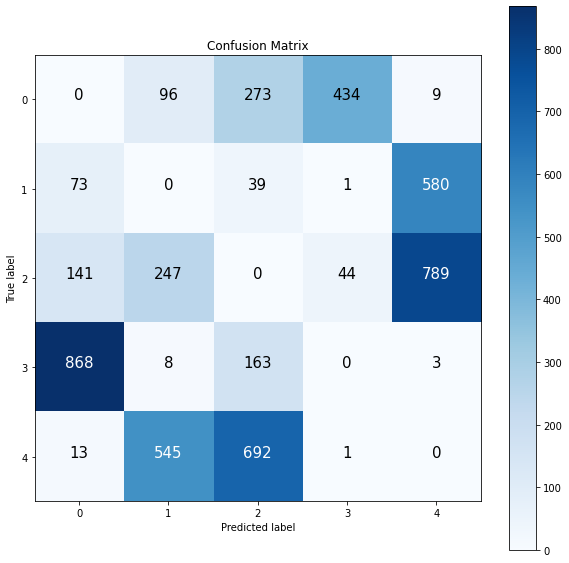

In [196]:
from helper_functions import make_confusion_matrix
make_confusion_matrix (Sorted_Results.GroundTruth, Sorted_Results.Predictions)

In [202]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Train model_5 on all of the data in the training dataset 
for as many epochs until it stops improving. Since this might take a while, you might want to use:

`tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.

`tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation loss has stopped improving for ~3 epochs.

In [205]:
earlystoppingcallback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
modelcheckpoints = tf.keras.callbacks.ModelCheckpoint(filepath="/content/save",
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         mode="auto",
                                                         save_best_only=True)

In [211]:
history_5 = model_5.fit(train_tribid_dataset,
                        epochs=50,
                        validation_data=val_tribid_dataset,
                        callbacks = [earlystoppingcallback, modelcheckpoints]
                        )

Epoch 1/50
5627/5627 [==============================] - 308s 55ms/step - loss: 0.8568 - accuracy: 0.8930 - val_loss: 0.9031 - val_accuracy: 0.8537
Epoch 2/50
5627/5627 [==============================] - 295s 53ms/step - loss: 0.8540 - accuracy: 0.8951 - val_loss: 0.9029 - val_accuracy: 0.8539
Epoch 3/50
5627/5627 [==============================] - 291s 52ms/step - loss: 0.8515 - accuracy: 0.8981 - val_loss: 0.9034 - val_accuracy: 0.8533
Epoch 4/50
5627/5627 [==============================] - 291s 52ms/step - loss: 0.8494 - accuracy: 0.8995 - val_loss: 0.9043 - val_accuracy: 0.8537


In [217]:
y_prediction_probabilities = model_5.predict(val_tribid_dataset)

y_predictions = tf.argmax(y_prediction_probabilities, axis=1)


945/945 [==============================] - 19s 20ms/step


In [219]:

y_predictions = tf.argmax(y_prediction_probabilities, axis=1)

In [221]:
model_5_full_set_results = calculate_results(y_true= val_labels_encoded,
                                             y_pred = y_predictions)

model_5_full_set_results

{'accuracy': 85.37336157818085,
 'precision': 0.8552492439272047,
 'recall': 0.8537336157818085,
 'f1': 0.8509263315275785}

In [222]:
model_5_results

{'accuracy': 83.38739573679332,
 'precision': 0.8333437984209839,
 'recall': 0.8338739573679332,
 'f1': 0.8324875589353418}

## GloVe embeddings
https://keras.io/examples/nlp/pretrained_word_embeddings/
Checkout the Keras guide on using pretrained GloVe embeddings. Can you get this working with one of our models?

In [224]:
# downloading the GloVe embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-03-13 17:48:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-13 17:48:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-13 17:48:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [227]:
path_to_glove_file = "/content/glove.6B.100d.txt"

In [228]:
embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print ("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [236]:
pd.DataFrame(embeddings_index).transpose().head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,-0.038194,-0.244870,0.72812,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.57545,0.087459,...,0.016215,-0.017099,-0.389840,0.87424,-0.72569,-0.51058,-0.520280,-0.14590,0.82780,0.270620
",",-0.107670,0.110530,0.59812,-0.543610,0.673960,0.106630,0.038867,0.354810,0.06351,-0.094189,...,0.349510,-0.722600,0.375490,0.44410,-0.99059,0.61214,-0.351110,-0.83155,0.45293,0.082577
.,-0.339790,0.209410,0.46348,-0.647920,-0.383770,0.038034,0.171270,0.159780,0.46619,-0.019169,...,-0.063351,-0.674120,-0.068895,0.53604,-0.87773,0.31802,-0.392420,-0.23394,0.47298,-0.028803
of,-0.152900,-0.242790,0.89837,0.169960,0.535160,0.487840,-0.588260,-0.179820,-1.35810,0.425410,...,0.187120,-0.018488,-0.267570,0.72700,-0.59363,-0.34839,-0.560940,-0.59100,1.00390,0.206640
to,-0.189700,0.050024,0.19084,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.20135,0.342410,...,-0.131340,0.058617,-0.318690,-0.61419,-0.62393,-0.41548,-0.038175,-0.39804,0.47647,-0.159830


In [235]:
embeddings_index["the"]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [237]:
text_vectorizer

In [238]:
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

In [242]:
output = text_vectorizer("the cast sat on a mat")
output

<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([    2,  6824,  8370,    18,     8, 12001,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

In [244]:
output = text_vectorizer([["the cast sat on a mat"]])
output

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[    2,  6824,  8370,    18,     8, 12001,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [251]:
vocabulary = text_vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
word_index

{'': 0,
 '[UNK]': 1,
 'the': 2,
 'and': 3,
 'of': 4,
 'in': 5,
 'to': 6,
 'with': 7,
 'a': 8,
 'were': 9,
 'was': 10,
 'for': 11,
 'patients': 12,
 'group': 13,
 'p': 14,
 'at': 15,
 'or': 16,
 'study': 17,
 'on': 18,
 'treatment': 19,
 'is': 20,
 'after': 21,
 'by': 22,
 'this': 23,
 'groups': 24,
 'as': 25,
 'an': 26,
 'from': 27,
 'that': 28,
 'randomized': 29,
 'between': 30,
 'not': 31,
 'trial': 32,
 'no': 33,
 'compared': 34,
 'control': 35,
 'be': 36,
 'significant': 37,
 'intervention': 38,
 'significantly': 39,
 'n': 40,
 'months': 41,
 'than': 42,
 'we': 43,
 'vs': 44,
 'rsb': 45,
 'lsb': 46,
 'clinical': 47,
 'placebo': 48,
 'baseline': 49,
 'ci': 50,
 'two': 51,
 'during': 52,
 'weeks': 53,
 'both': 54,
 'had': 55,
 'primary': 56,
 'mean': 57,
 'are': 58,
 'using': 59,
 'participants': 60,
 'there': 61,
 'all': 62,
 'time': 63,
 'years': 64,
 'pain': 65,
 'therapy': 66,
 'who': 67,
 'mg': 68,
 'more': 69,
 'effect': 70,
 'effects': 71,
 'but': 72,
 'risk': 73,
 'difference

In [252]:
help(word_index)

Help on dict object:

class dict(object)
 |  dict() -> new empty dictionary
 |  dict(mapping) -> new dictionary initialized from a mapping object's
 |      (key, value) pairs
 |  dict(iterable) -> new dictionary initialized as if via:
 |      d = {}
 |      for k, v in iterable:
 |          d[k] = v
 |  dict(**kwargs) -> new dictionary initialized with the name=value pairs
 |      in the keyword argument list.  For example:  dict(one=1, two=2)
 |  
 |  Built-in subclasses:
 |      StgDict
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      True if the dictionary has the specified key, else False.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>va

In [ ]:
max_tokens = 68000 # taken from the paper

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [278]:
# make the embedding matrix i.e. mapping each word in our text_vectorizer vocabulary to the corresponding array in embedding_index

num_tokens = len(text_vectorizer.get_vocabulary())

embedding_dim = 100
hits = 0
misses = 0

# prepare embedding matrix

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros
    # this includes the representation for padding and 'OOV'
   embedding_matrix[i] = embedding_vector
   hits +=1
  else:
    misses +=1

print ("converted %d words (with %d misses)" % (hits,misses))

converted 29730 words (with 35111 misses)


In [277]:
from tensorflow.keras.layers import Embedding
from tensorflow import keras



In [261]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    trainable=False
)

In [283]:
# build the model
inputs = layers.Input(shape=[], dtype = "string", name="input_layer")
x = embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(x) # you could add more layers here if you want to

x = layers.Dense(8, activation="relu")(x)

outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_2_glove = tf.keras.Model(inputs, outputs, name = "model_2_gloVe")


model_2_glove.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")
model_2_glove.summary()



Model: "model_2_gloVe"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 embedding (Embedding)       (None, 100)               6484100   
                                                                 
 dense_24 (Dense)            (None, 128)               12928     
                                                                 
 dense_25 (Dense)            (None, 8)                 1032      
                                                                 
 dense_26 (Dense)            (None, 5)                 45        
                                                                 
Total params: 6,498,105
Trainable params: 14,005
Non-trainable params: 6,484,100
_________________________________________________________________


In [284]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dense_16 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [282]:
history_2_glove = model_2_glove.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        validation_data = valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3


UnimplementedError: ignored

In [ ]:
model_2_glove.evaluate(valid_dataset)
model_2_glove_results = check_accuracy(y_true = 
                                       y_pred = )

y_pred = tf.argmax(model_2_glove.predict(valid_dataset), axis=1)